## BIBLIOTEKOS ##

In [1]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, confusion_matrix

## DUOMENŲ PARUOŠIMAS ##

In [2]:
path = kagglehub.dataset_download("parulpandey/emotion-dataset")

print("Path to dataset files:", path)

train_path = os.path.join(path, "training.csv")
df = pd.read_csv(train_path)

test_path = os.path.join(path, "test.csv")
df_test = pd.read_csv(test_path)

validation_path = os.path.join(path, "validation.csv")
df_val = pd.read_csv(validation_path)


#  Apjungiame train + test duomenis
df_full = pd.concat([df, df_test, df_val], axis=0)
print(f"Bendras įrašų skaičius: {len(df_full)}")


Path to dataset files: C:\Users\ignas\.cache\kagglehub\datasets\parulpandey\emotion-dataset\versions\1
Bendras įrašų skaičius: 20000


In [3]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    #text = re.sub(r'(href http)|(img src http s)', '', text)
    return text

df_full['clean_text'] = df_full['text'].apply(clean_text)

df_full.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ignas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,clean_text
0,i didnt feel humiliated,0,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,0,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,3,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,3,feeling grouchy


## PRADINĖ ANALIZĖ ##

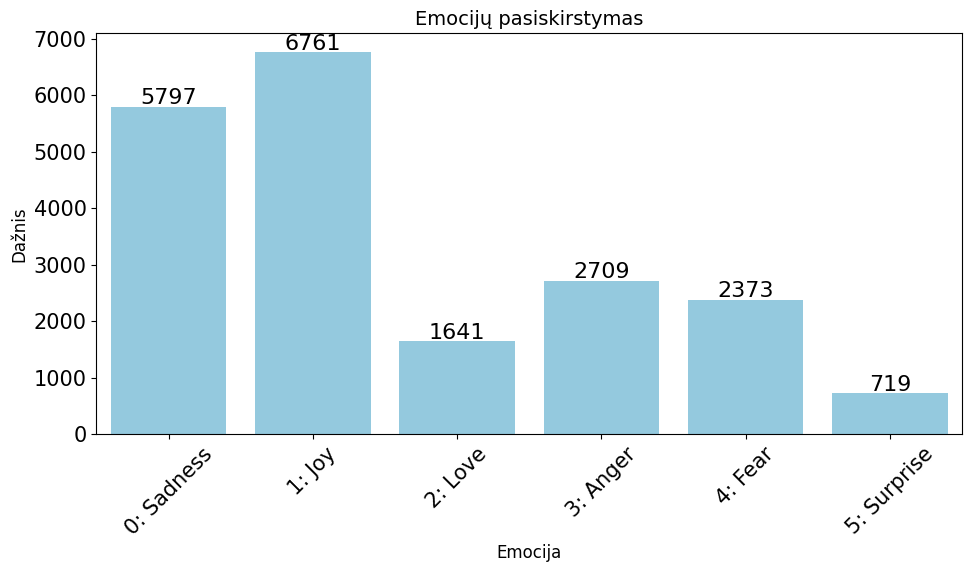

In [57]:
emotion_labels = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']


plt.rcParams.update({
    'font.size': 16,          
    'axes.titlesize': 15,     
    'axes.labelsize': 15,     
    'xtick.labelsize': 15,    
    'ytick.labelsize': 15,    
    'legend.fontsize': 13,    
})

plt.figure(figsize=(10, 6))
sns.countplot(data=df_full, x='label', color='skyblue')
plt.title('Emocijų pasiskirstymas', fontsize=14)
plt.xlabel('Emocija', fontsize=12)
plt.ylabel('Dažnis', fontsize=12)

plt.xticks(range(6), [f'{i}: {emotion_labels[i]}' for i in range(6)], rotation=45)

for i, v in enumerate(df_full['label'].value_counts().sort_index()):
    plt.text(i, v + 50, str(v), ha='center')

plt.tight_layout()
plt.show()


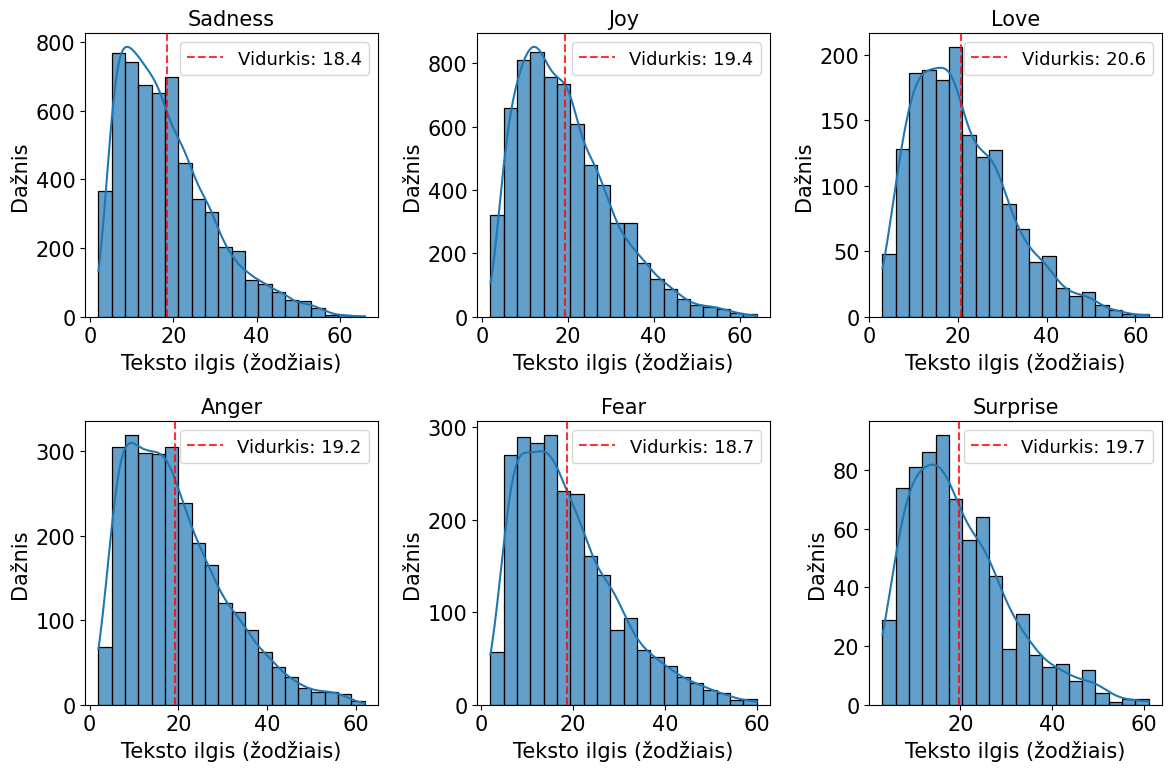

Teksto ilgio statistika pagal emociją:
--------------------------------------------------
Sadness (Label 0):
  Vidurkis: 18.41
  Mediana: 16.00
  Standartinis nuokrypis: 11.02
  Min: 2
  Max: 66

Joy (Label 1):
  Vidurkis: 19.43
  Mediana: 17.00
  Standartinis nuokrypis: 10.83
  Min: 2
  Max: 64

Love (Label 2):
  Vidurkis: 20.61
  Mediana: 19.00
  Standartinis nuokrypis: 10.74
  Min: 3
  Max: 63

Anger (Label 3):
  Vidurkis: 19.25
  Mediana: 17.00
  Standartinis nuokrypis: 11.28
  Min: 2
  Max: 62

Fear (Label 4):
  Vidurkis: 18.74
  Mediana: 16.00
  Standartinis nuokrypis: 10.90
  Min: 2
  Max: 60

Surprise (Label 5):
  Vidurkis: 19.71
  Mediana: 17.00
  Standartinis nuokrypis: 11.03
  Min: 3
  Max: 61



In [55]:
df_full['text_length'] = df_full['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 8))


plt.rcParams.update({
    'font.size': 16,          
    'axes.titlesize': 15,     
    'axes.labelsize': 15,     
    'xtick.labelsize': 15,    
    'ytick.labelsize': 15,    
    'legend.fontsize': 13,    
})
for i, label in enumerate(sorted(df_full['label'].unique())):
    plt.subplot(2, 3, i+1)
    label_data = df_full[df_full['label'] == label]['text_length']

    sns.histplot(label_data, bins=20, kde=True, alpha=0.7)
    plt.title(f'{emotion_labels[label]}')
    plt.xlabel('Teksto ilgis (žodžiais)')
    plt.ylabel('Dažnis')
    mean_length = label_data.mean()
    plt.axvline(mean_length, color='red', linestyle='--', alpha=0.8,
                label=f'Vidurkis: {mean_length:.1f}')
    plt.legend()

plt.tight_layout()
plt.show()

print("Teksto ilgio statistika pagal emociją:")
print("-" * 50)
for label in sorted(df_full['label'].unique()):
    label_data = df_full[df_full['label'] == label]['text_length']
    print(f"{emotion_labels[label]} (Label {label}):")
    print(f"  Vidurkis: {label_data.mean():.2f}")
    print(f"  Mediana: {label_data.median():.2f}")
    print(f"  Standartinis nuokrypis: {label_data.std():.2f}")
    print(f"  Min: {label_data.min()}")
    print(f"  Max: {label_data.max()}")
    print()


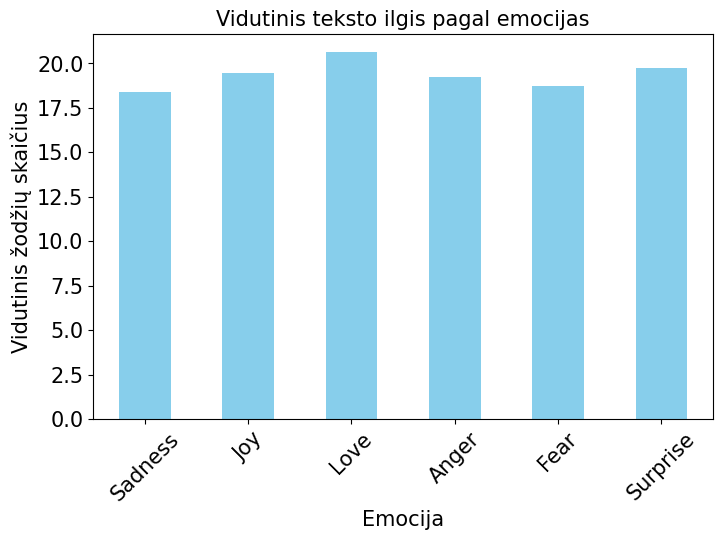

In [53]:
avg_len = df_full.groupby('label')['text_length'].mean()
emotion_labels = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']


plt.rcParams.update({
    'font.size': 16,          
    'axes.titlesize': 15,     
    'axes.labelsize': 15,     
    'xtick.labelsize': 15,    
    'ytick.labelsize': 15,    
    'legend.fontsize': 13,    
})

plt.figure(figsize=(8,5))
avg_len.plot(kind='bar', color='skyblue')
plt.title('Vidutinis teksto ilgis pagal emocijas')
plt.xlabel('Emocija')
plt.xticks(ticks=range(len(emotion_labels)), labels=emotion_labels, rotation=45)
plt.ylabel('Vidutinis žodžių skaičius')
plt.show()


In [7]:
from collections import Counter

for label in sorted(df_full['label'].unique()):
    all_words = ' '.join(df_full[df_full['label'] == label]['clean_text']).split()
    freq = Counter(all_words).most_common(10)
    print(f"\nTop words for label {label}:")
    for word, count in freq:
        print(f"{word}: {count}")

#Cia gaunasi kad visose emocijose pirmi 4 zodziai yra tokie patys, todel braizant wordclouda jie uzgozia kitus zodzius ir nesimato skirtumu,
#todel galima nubraizyti be siu zodziu


Top words for label 0:
feel: 4079
feeling: 1913
like: 1064
im: 875
really: 349
know: 339
get: 284
ive: 266
little: 256
time: 255

Top words for label 1:
feel: 4942
feeling: 1949
like: 1256
im: 1007
really: 377
time: 359
know: 322
get: 309
make: 274
people: 265

Top words for label 2:
feel: 1180
feeling: 471
like: 393
im: 251
love: 119
really: 112
know: 101
sweet: 84
loving: 82
time: 82

Top words for label 3:
feel: 1796
feeling: 918
like: 475
im: 426
really: 165
get: 150
know: 148
people: 144
time: 141
little: 133

Top words for label 4:
feel: 1479
feeling: 924
im: 383
like: 311
little: 186
bit: 143
know: 137
really: 125
still: 115
time: 113

Top words for label 5:
feel: 462
feeling: 256
like: 117
im: 113
amazed: 83
impressed: 72
curious: 72
overwhelmed: 69
funny: 68
surprised: 68


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ignas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


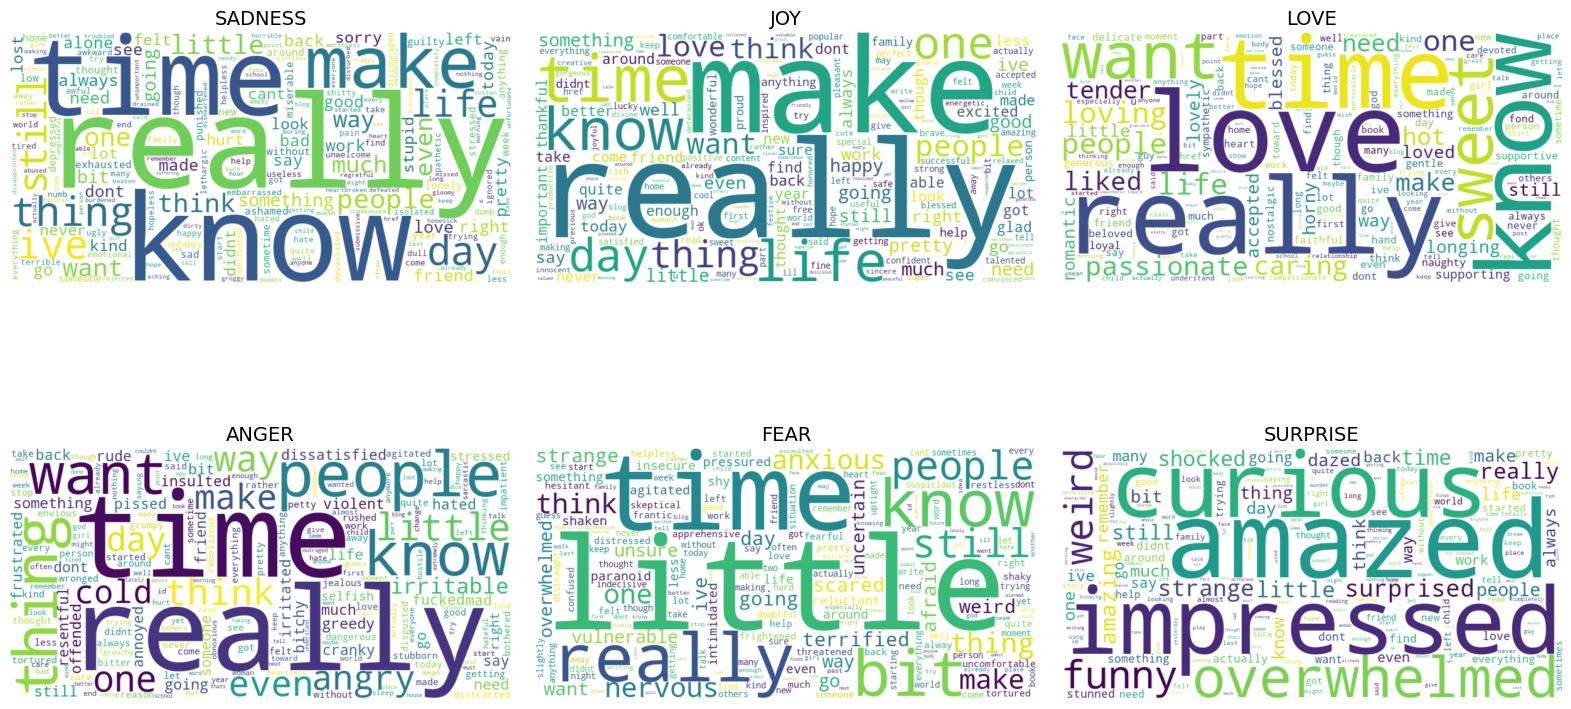

In [54]:
import collections
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()


plt.rcParams.update({
    'font.size': 16,          
    'axes.titlesize': 15,     
    'axes.labelsize': 15,     
    'xtick.labelsize': 15,    
    'ytick.labelsize': 15,    
    'legend.fontsize': 13,    
})

def clean_text_with_lemmas(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

df_full['lemmatized_text'] = df_full['text'].apply(clean_text_with_lemmas)

emotion_names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

labels = sorted(df_full['label'].unique())
plt.figure(figsize=(16, 10))

for i, label in enumerate(labels):
    text = ' '.join(df_full[df_full['label'] == label]['lemmatized_text']).split()
    word_freq = collections.Counter(text)
    most_common_words = [w for w, _ in word_freq.most_common(4)]
    filtered_words = [w for w in text if w not in most_common_words]

    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='viridis'
    ).generate(' '.join(filtered_words))

    plt.subplot(2, (len(labels) + 1)//2, i + 1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{emotion_names[label].upper()}", fontsize=14)

plt.tight_layout()
plt.show()

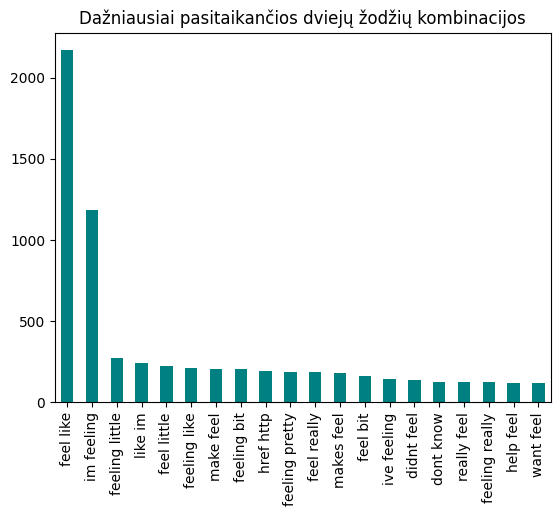

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=20)
X = cv.fit_transform(df_full['clean_text'])
bigrams = pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out())
bigrams_sum = bigrams.sum().sort_values(ascending=False)
bigrams_sum.head(20).plot(kind='bar', color='teal')
plt.title('Dažniausiai pasitaikančios dviejų žodžių kombinacijos')
plt.show()


5 dažniausi POS tag'ai kiekvienoje emocinėje kategorijoje (be stop words):

SADNESS:
  VERB: 16682
  NOUN: 14342
  ADJ: 9363
  ADV: 4797
  AUX: 2651

ANGER:
  VERB: 8054
  NOUN: 7034
  ADJ: 4547
  ADV: 2207
  AUX: 1299

LOVE:
  NOUN: 5074
  VERB: 4960
  ADJ: 2570
  ADV: 1334
  AUX: 754

SURPRISE:
  VERB: 2115
  NOUN: 2014
  ADJ: 1328
  ADV: 637
  AUX: 277

FEAR:
  VERB: 6791
  NOUN: 6133
  ADJ: 4269
  ADV: 1980
  AUX: 973

JOY:
  VERB: 19083
  NOUN: 18899
  ADJ: 11870
  ADV: 5630
  AUX: 2799



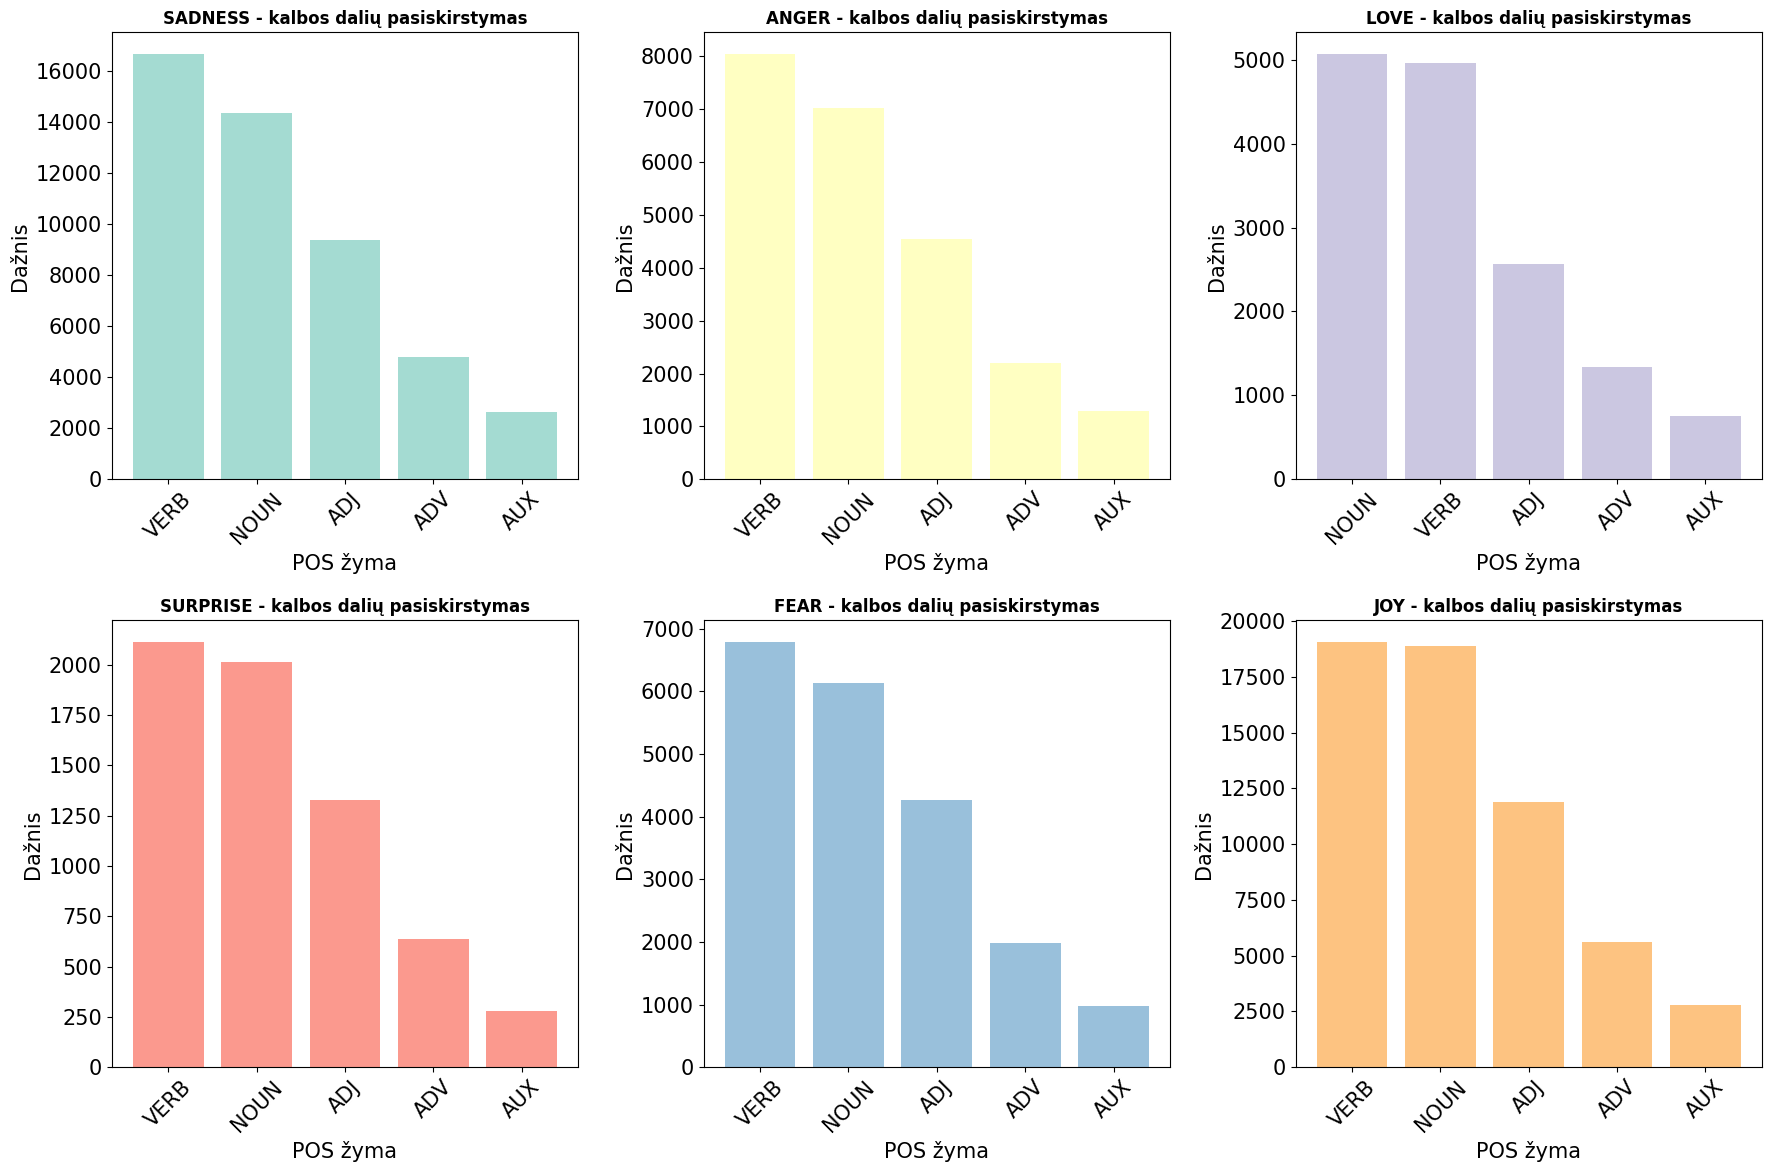

In [52]:
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")


plt.rcParams.update({
    'font.size': 16,          
    'axes.titlesize': 15,     
    'axes.labelsize': 15,     
    'xtick.labelsize': 15,    
    'ytick.labelsize': 15,    
    'legend.fontsize': 13,    
})

def get_pos_counts_clean(text):
    doc = nlp(text)
    pos_counts = Counter()
    for token in doc:
        if not token.is_space:
            pos_counts[token.pos_] += 1

    return dict(pos_counts)


df_full['pos_counts'] = df_full['clean_text'].apply(get_pos_counts_clean)

emotion_pos_data = {}

for emotion in df_full['label'].unique():
    emotion_data = df_full[df_full['label'] == emotion]
    all_pos_counts = Counter()
    for pos_dict in emotion_data['pos_counts']:
        all_pos_counts.update(pos_dict)
    emotion_pos_data[emotion] = all_pos_counts

print("5 dažniausi POS tag'ai kiekvienoje emocinėje kategorijoje (be stop words):\n")
for emotion, pos_counts in emotion_pos_data.items():
    emotion_name = emotion_names[emotion]
    top_5_pos = pos_counts.most_common(5)
    print(f"{emotion_name.upper()}:")
    for pos_tag, count in top_5_pos:
        print(f"  {pos_tag}: {count}")
    print()


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (emotion, pos_counts) in enumerate(emotion_pos_data.items()):
    emotion_name = emotion_names[emotion]
    top_5_pos = dict(pos_counts.most_common(5))
    axes[i].bar(top_5_pos.keys(), top_5_pos.values(),
                color=plt.cm.Set3(i), alpha=0.8)
    axes[i].set_title(f'{emotion_name.upper()} - kalbos dalių pasiskirstymas',
                      fontsize=12, fontweight='bold')
    axes[i].set_xlabel('POS žyma')
    axes[i].set_ylabel('Dažnis')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [11]:
all_words = ' '.join(df_full['clean_text']).split()
unique_words = set(all_words)
print(f"Total unique words: {len(unique_words)}")

Total unique words: 16947


## ML TAIKYMAS ##

In [12]:
from sklearn.model_selection import train_test_split

X = df_full['lemmatized_text']
y = df_full['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    sublinear_tf=True
)


## TF-IDF ##

In [13]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Logistine su Tf-Idf

In [14]:
from sklearn.linear_model import LogisticRegression

pipeline_tfidf_logreg = Pipeline([
    ('tfidf', tfidf),
    ('logreg', LogisticRegression(max_iter=2000, random_state=42))
])

param_grid_logreg = {'logreg__C': [0.01, 0.1, 1, 10, 100]}

grid_search_tfidf_logreg = GridSearchCV(
    estimator=pipeline_tfidf_logreg,
    param_grid=param_grid_logreg,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_tfidf_logreg.fit(X_train, y_train)
print("Best parameters (TF-IDF + Logistic Regression):", grid_search_tfidf_logreg.best_params_)

best_C_logreg = grid_search_tfidf_logreg.best_params_['logreg__C']
best_cv_score_logreg = grid_search_tfidf_logreg.best_score_

pipeline_best_tfidf_logreg = Pipeline([
    ('tfidf', tfidf),
    ('logreg', LogisticRegression(C=best_C_logreg, max_iter=2000, random_state=42))
])

cv_scores_tfidf_logreg = cross_val_score(pipeline_best_tfidf_logreg, X, y, cv=10, scoring='accuracy', n_jobs=-1)

best_model_tfidf_logreg = grid_search_tfidf_logreg.best_estimator_
y_pred_logreg_tfidf = best_model_tfidf_logreg.predict(X_test)


Best parameters (TF-IDF + Logistic Regression): {'logreg__C': 10}


Classification Report - TF-IDF + Logistic Regression:
               precision    recall  f1-score   support

           0      0.938     0.946     0.942      1159
           1      0.903     0.954     0.928      1352
           2      0.869     0.750     0.805       328
           3      0.918     0.884     0.900       542
           4      0.890     0.865     0.877       475
           5      0.778     0.729     0.753       144

    accuracy                          0.907      4000
   macro avg      0.882     0.855     0.867      4000
weighted avg      0.906     0.907     0.906      4000



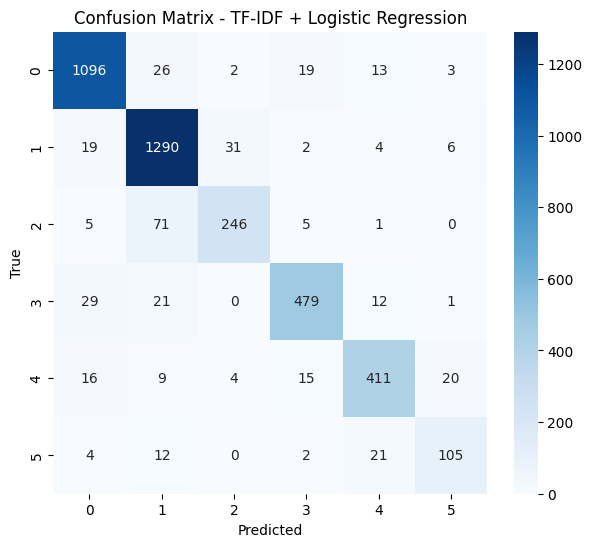

In [15]:
from sklearn.metrics import f1_score

cr_logreg_tfidf=classification_report(y_test, y_pred_logreg_tfidf, digits=3)
print("Classification Report - TF-IDF + Logistic Regression:\n", cr_logreg_tfidf)
cm_tfidf_logreg = confusion_matrix(y_test, y_pred_logreg_tfidf)

plt.figure(figsize=(7,6))
sns.heatmap(cm_tfidf_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model_tfidf_logreg.classes_,
            yticklabels=best_model_tfidf_logreg.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - TF-IDF + Logistic Regression")
plt.show()

K-NN su Tf-Idf

In [16]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

pipeline_tfidf_knn = Pipeline([
    ('tfidf', tfidf),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'knn__n_neighbors': np.arange(3, 15, 1),
    'knn__weights': ['uniform', 'distance']
}

grid_search_tfidf_knn = GridSearchCV(
    estimator=pipeline_tfidf_knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_tfidf_knn.fit(X_train, y_train)

print("Best parameters (TF-IDF + KNN):", grid_search_tfidf_knn.best_params_)

pipeline_best_tfidf_knn = Pipeline([
    ('tfidf', tfidf),
    ('knn', KNeighborsClassifier(
        n_neighbors=grid_search_tfidf_knn.best_params_['knn__n_neighbors'],
        weights=grid_search_tfidf_knn.best_params_['knn__weights']
    ))
])

cv_scores_tfidf_knn = cross_val_score(pipeline_best_tfidf_knn, X, y, cv=10, scoring='accuracy', n_jobs=-1)


best_model_tfidf_knn = grid_search_tfidf_knn.best_estimator_
y_pred_knn = best_model_tfidf_knn.predict(X_test)

Best parameters (TF-IDF + KNN): {'knn__n_neighbors': np.int64(14), 'knn__weights': 'uniform'}


Classification Report - TF-IDF + KNN:
               precision    recall  f1-score   support

           0      0.779     0.837     0.807      1159
           1      0.724     0.884     0.796      1352
           2      0.919     0.415     0.571       328
           3      0.911     0.642     0.753       542
           4      0.711     0.756     0.733       475
           5      0.841     0.403     0.545       144

    accuracy                          0.766      4000
   macro avg      0.814     0.656     0.701      4000
weighted avg      0.784     0.766     0.758      4000



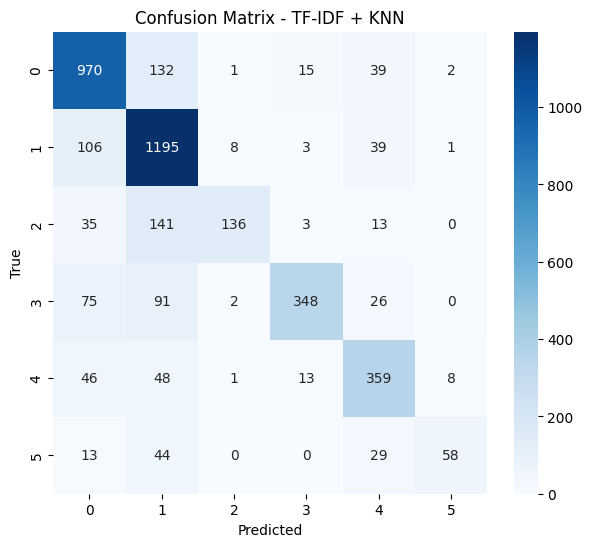

In [17]:
cr_knn_tfidf = classification_report(y_test, y_pred_knn, digits=3)
print("Classification Report - TF-IDF + KNN:\n", cr_knn_tfidf)

cm_tfidf_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(7,6))
sns.heatmap(cm_tfidf_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model_tfidf_knn.classes_,
            yticklabels=best_model_tfidf_knn.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - TF-IDF + KNN")
plt.show()


SVM su TF-IDF

In [18]:
from sklearn.svm import LinearSVC

pipeline_tfidf_svc = Pipeline([
    ('tfidf', tfidf),
    ('svc', LinearSVC(random_state=42))
])

param_grid_svc = {
    'svc__C': [0.01, 0.1, 1, 10, 100]
}

# Grid Search
grid_search_tfidf_svc = GridSearchCV(
    estimator=pipeline_tfidf_svc,
    param_grid=param_grid_svc,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_tfidf_svc.fit(X_train, y_train)

print("Best parameters (TF-IDF + SVM):", grid_search_tfidf_svc.best_params_)

pipeline_best_tfidf_svc = Pipeline([
    ('tfidf', tfidf),
    ('svc', LinearSVC(
        C=grid_search_tfidf_svc.best_params_['svc__C'],
        random_state=42
    ))
])

cv_scores_tfidf_svc = cross_val_score(
    pipeline_best_tfidf_svc,
    X, y,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

best_model_tfidf_svc = grid_search_tfidf_svc.best_estimator_
y_pred_svc = best_model_tfidf_svc.predict(X_test)


Best parameters (TF-IDF + SVM): {'svc__C': 1}


Classification Report - TF-IDF + SVM:
               precision    recall  f1-score   support

           0      0.945     0.947     0.946      1159
           1      0.913     0.950     0.931      1352
           2      0.871     0.784     0.825       328
           3      0.917     0.897     0.907       542
           4      0.883     0.874     0.878       475
           5      0.797     0.764     0.780       144

    accuracy                          0.912      4000
   macro avg      0.888     0.869     0.878      4000
weighted avg      0.912     0.912     0.912      4000



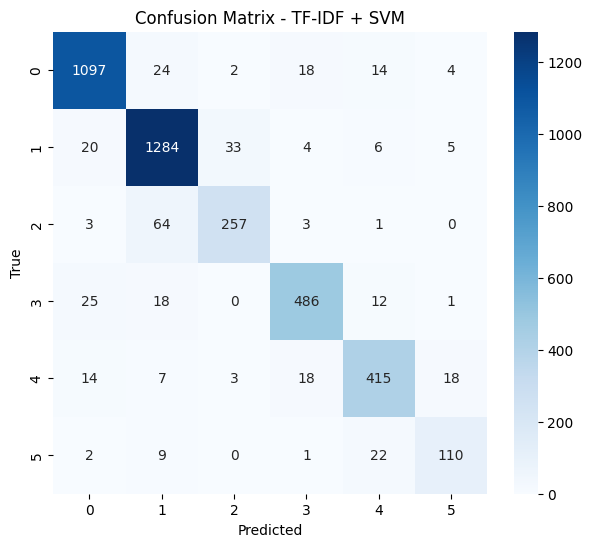

In [19]:
cr_svc_tfidf = classification_report(y_test, y_pred_svc, digits=3)
print("Classification Report - TF-IDF + SVM:\n", cr_svc_tfidf)

cm_tfidf_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(7,6))
sns.heatmap(cm_tfidf_svc, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model_tfidf_svc.classes_,
            yticklabels=best_model_tfidf_svc.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - TF-IDF + SVM")
plt.show()

NB su TF-IDF

In [20]:
from sklearn.naive_bayes import MultinomialNB

pipeline_tfidf_nb = Pipeline([
    ('tfidf', tfidf),
    ('nb', MultinomialNB())
])

param_grid_nb = {
    'nb__alpha': [0.01, 0.1, 0.5, 1.0]
}

grid_search_tfidf_nb = GridSearchCV(
    estimator=pipeline_tfidf_nb,
    param_grid=param_grid_nb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_tfidf_nb.fit(X_train, y_train)

print("Best parameters (TF-IDF + NB):", grid_search_tfidf_nb.best_params_)

pipeline_best_tfidf_nb = Pipeline([
    ('tfidf', tfidf),
    ('nb', MultinomialNB(
        alpha=grid_search_tfidf_nb.best_params_['nb__alpha']
    ))
])

cv_scores_tfidf_nb = cross_val_score(
    pipeline_best_tfidf_nb,
    X, y,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

best_model_tfidf_nb = grid_search_tfidf_nb.best_estimator_
y_pred_nb = best_model_tfidf_nb.predict(X_test)

Best parameters (TF-IDF + NB): {'nb__alpha': 0.1}


Classification Report - TF-IDF + Naive Bayes:
               precision    recall  f1-score   support

           0      0.850     0.946     0.895      1159
           1      0.825     0.954     0.885      1352
           2      0.898     0.561     0.690       328
           3      0.929     0.793     0.856       542
           4      0.884     0.754     0.814       475
           5      0.811     0.417     0.550       144

    accuracy                          0.855      4000
   macro avg      0.866     0.737     0.782      4000
weighted avg      0.859     0.855     0.848      4000



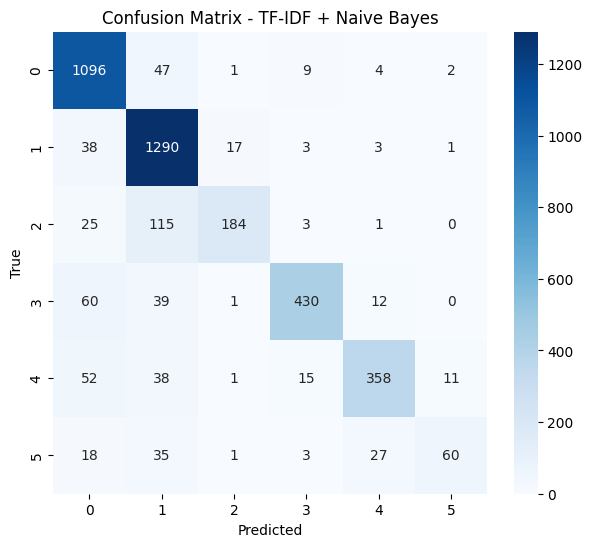

In [21]:
cr_nb_tfidf = classification_report(y_test, y_pred_nb, digits=3)
print("Classification Report - TF-IDF + Naive Bayes:\n", cr_nb_tfidf)

cm_tfidf_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(7,6))
sns.heatmap(cm_tfidf_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model_tfidf_nb.classes_,
            yticklabels=best_model_tfidf_nb.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - TF-IDF + Naive Bayes")
plt.show()

## CountVector ##

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
cvec=CountVectorizer(
        max_features=5000,
        ngram_range=(1,2)
    )

Logistinie su CountVector

In [24]:
from sklearn.linear_model import LogisticRegression

pipeline_count_logreg = Pipeline([
    ('countvec', cvec),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid_logreg = {
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

grid_search_count_logreg = GridSearchCV(
    estimator=pipeline_count_logreg,
    param_grid=param_grid_logreg,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_count_logreg.fit(X_train, y_train)

print("Best parameters (CountVec + Logistic Regression):", grid_search_count_logreg.best_params_)

pipeline_best_count_logreg = Pipeline([
    ('countvec', cvec),
    ('logreg', LogisticRegression(
        C=grid_search_count_logreg.best_params_['logreg__C'],
        max_iter=1000,
        random_state=42
    ))
])

cv_scores_count_logreg = cross_val_score(
    pipeline_best_count_logreg,
    X, y,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

best_model_count_logreg = grid_search_count_logreg.best_estimator_
y_pred_count_logreg = best_model_count_logreg.predict(X_test)

Best parameters (CountVec + Logistic Regression): {'logreg__C': 1}


Classification Report - CountVec + Logistic Regression:
               precision    recall  f1-score   support

           0      0.946     0.945     0.946      1159
           1      0.913     0.956     0.934      1352
           2      0.867     0.793     0.828       328
           3      0.909     0.884     0.896       542
           4      0.879     0.876     0.878       475
           5      0.797     0.708     0.750       144

    accuracy                          0.911      4000
   macro avg      0.885     0.860     0.872      4000
weighted avg      0.910     0.911     0.910      4000



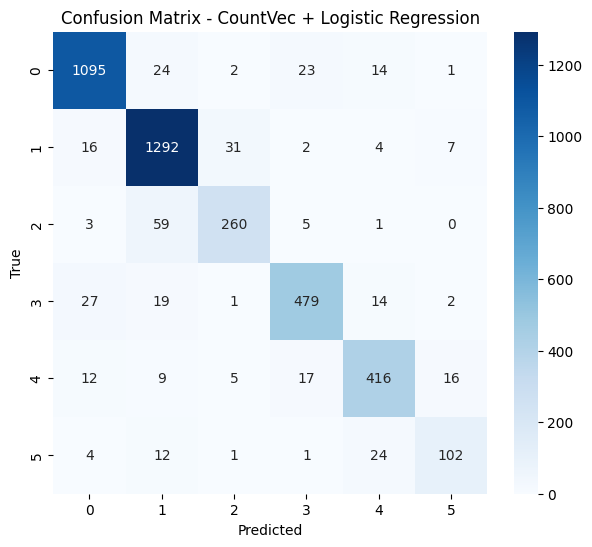

In [25]:
cr_count_logreg = classification_report(y_test, y_pred_count_logreg, digits=3)
print("Classification Report - CountVec + Logistic Regression:\n", cr_count_logreg)


cm_count_logreg = confusion_matrix(y_test, y_pred_count_logreg)
plt.figure(figsize=(7,6))
sns.heatmap(cm_count_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model_count_logreg.classes_,
            yticklabels=best_model_count_logreg.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CountVec + Logistic Regression")
plt.show()


KNN su CountVector

In [26]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_count_knn = Pipeline([
    ('countvec', cvec),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'knn__n_neighbors': np.arange(3, 15, 1),
    'knn__weights': ['uniform', 'distance']
}

grid_search_count_knn = GridSearchCV(
    estimator=pipeline_count_knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_count_knn.fit(X_train, y_train)

print("Best parameters (CountVec + KNN):", grid_search_count_knn.best_params_)

pipeline_best_count_knn = Pipeline([
    ('countvec', cvec),
    ('knn', KNeighborsClassifier(
        n_neighbors=grid_search_count_knn.best_params_['knn__n_neighbors'],
        weights=grid_search_count_knn.best_params_['knn__weights']
    ))
])

cv_scores_count_knn = cross_val_score(
    pipeline_best_count_knn,
    X, y,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

best_model_count_knn = grid_search_count_knn.best_estimator_
y_pred_count_knn = best_model_count_knn.predict(X_test)

Best parameters (CountVec + KNN): {'knn__n_neighbors': np.int64(4), 'knn__weights': 'distance'}


Classification Report - CountVec + KNN:
               precision    recall  f1-score   support

           0      0.644     0.728     0.684      1159
           1      0.707     0.717     0.712      1352
           2      0.667     0.390     0.492       328
           3      0.495     0.607     0.546       542
           4      0.653     0.507     0.571       475
           5      0.589     0.389     0.469       144

    accuracy                          0.642      4000
   macro avg      0.626     0.556     0.579      4000
weighted avg      0.646     0.642     0.638      4000



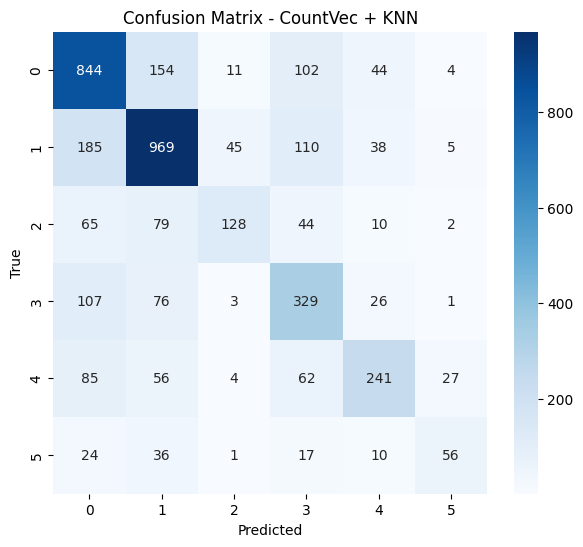

In [27]:
cr_count_knn = classification_report(y_test, y_pred_count_knn, digits=3)
print("Classification Report - CountVec + KNN:\n", cr_count_knn)

cm_count_knn = confusion_matrix(y_test, y_pred_count_knn)
plt.figure(figsize=(7,6))
sns.heatmap(cm_count_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model_count_knn.classes_,
            yticklabels=best_model_count_knn.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CountVec + KNN")
plt.show()

SVM su CountVector

In [28]:
from sklearn.svm import LinearSVC

pipeline_count_svc = Pipeline([
    ('countvec', cvec),
    ('svc', LinearSVC(random_state=42))
])

param_grid_count_svc = {
    'svc__C': [0.01, 0.1, 1, 10, 100]
}

grid_search_count_svc = GridSearchCV(
    estimator=pipeline_count_svc,
    param_grid=param_grid_count_svc,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_count_svc.fit(X_train, y_train)

print("Best parameters (CountVec + SVM):", grid_search_count_svc.best_params_)

pipeline_best_count_svc = Pipeline([
    ('countvec', cvec),
    ('svc', LinearSVC(
        C=grid_search_count_svc.best_params_['svc__C'],
        random_state=42
    ))
])

cv_scores_count_svc = cross_val_score(
    pipeline_best_count_svc,
    X, y,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

best_model_count_svc = grid_search_count_svc.best_estimator_
y_pred_count_svc = best_model_count_svc.predict(X_test)

Best parameters (CountVec + SVM): {'svc__C': 0.1}


Classification Report - CountVec + SVM:
               precision    recall  f1-score   support

           0      0.952     0.941     0.947      1159
           1      0.917     0.957     0.937      1352
           2      0.887     0.790     0.835       328
           3      0.911     0.902     0.906       542
           4      0.879     0.888     0.884       475
           5      0.799     0.743     0.770       144

    accuracy                          0.915      4000
   macro avg      0.891     0.870     0.880      4000
weighted avg      0.915     0.915     0.915      4000



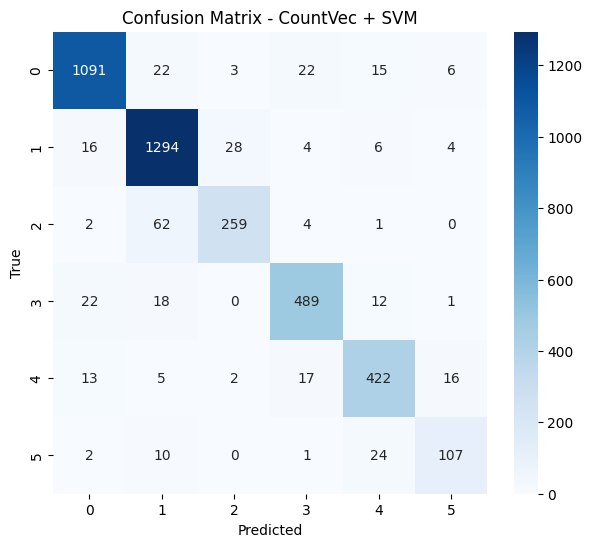

In [29]:
cr_count_svc = classification_report(y_test, y_pred_count_svc, digits=3)
print("Classification Report - CountVec + SVM:\n", cr_count_svc)

cm_count_svc = confusion_matrix(y_test, y_pred_count_svc)
plt.figure(figsize=(7,6))
sns.heatmap(cm_count_svc, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model_count_svc.classes_,
            yticklabels=best_model_count_svc.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CountVec + SVM")
plt.show()

NB su CountVector

In [30]:
pipeline_count_nb = Pipeline([
    ('countvec', cvec),
    ('nb', MultinomialNB())
])

# Hyperparameter grid
param_grid_count_nb = {
    'nb__alpha': [0.01, 0.1, 0.5, 1.0]
}

# Grid Search
grid_search_count_nb = GridSearchCV(
    estimator=pipeline_count_nb,
    param_grid=param_grid_count_nb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_count_nb.fit(X_train, y_train)

print("Best parameters (CountVec + NB):", grid_search_count_nb.best_params_)

# Best pipeline
pipeline_best_count_nb = Pipeline([
    ('countvec', cvec),
    ('nb', MultinomialNB(
        alpha=grid_search_count_nb.best_params_['nb__alpha']
    ))
])

# Cross-validation
cv_scores_count_nb = cross_val_score(
    pipeline_best_count_nb,
    X, y,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

# Evaluation on test data
best_model_count_nb = grid_search_count_nb.best_estimator_
y_pred_count_nb = best_model_count_nb.predict(X_test)

Best parameters (CountVec + NB): {'nb__alpha': 0.5}


Classification Report - CountVec + Naive Bayes:
               precision    recall  f1-score   support

           0      0.912     0.923     0.918      1159
           1      0.894     0.919     0.906      1352
           2      0.802     0.753     0.777       328
           3      0.870     0.867     0.869       542
           4      0.857     0.819     0.837       475
           5      0.709     0.660     0.683       144

    accuracy                          0.878      4000
   macro avg      0.841     0.824     0.832      4000
weighted avg      0.877     0.878     0.878      4000



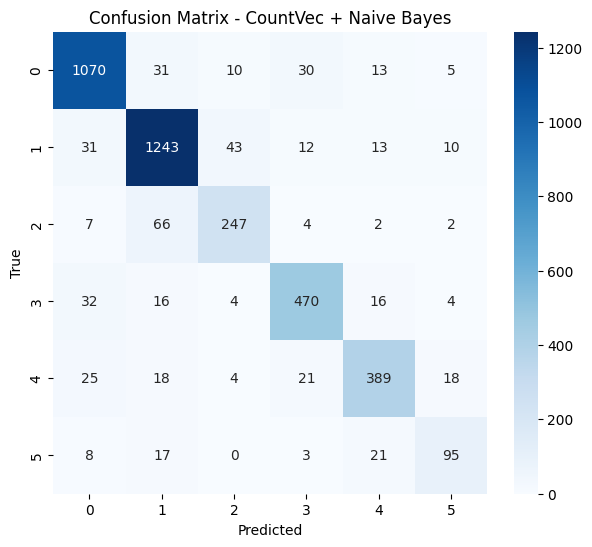

In [31]:
cr_count_nb = classification_report(y_test, y_pred_count_nb, digits=3)
print("Classification Report - CountVec + Naive Bayes:\n", cr_count_nb)

# Confusion Matrix
cm_count_nb = confusion_matrix(y_test, y_pred_count_nb)
plt.figure(figsize=(7,6))
sns.heatmap(cm_count_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model_count_nb.classes_,
            yticklabels=best_model_count_nb.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CountVec + Naive Bayes")
plt.show()

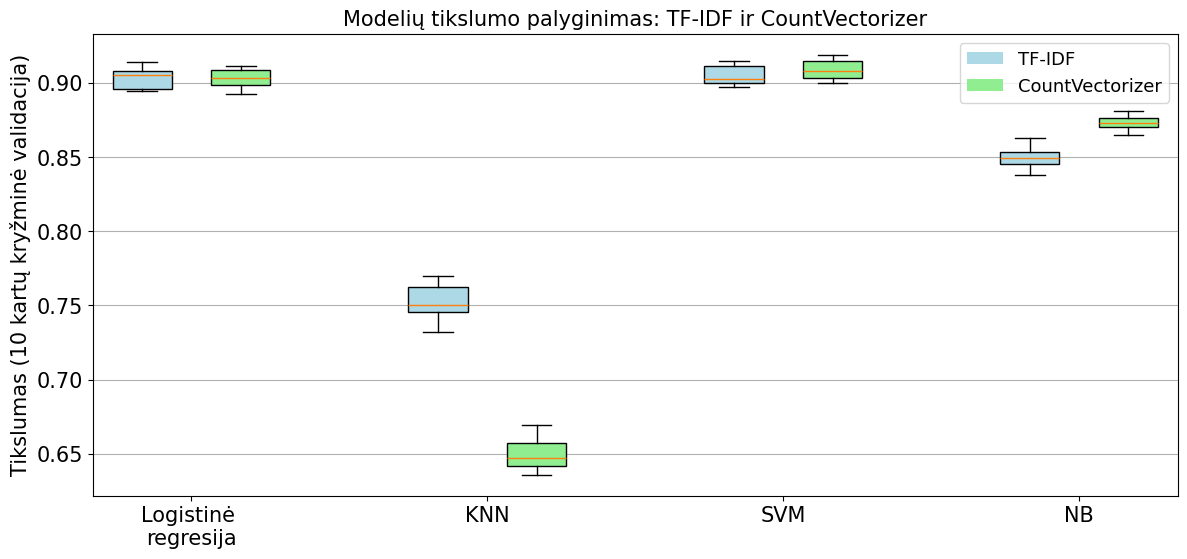

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

plt.rcParams.update({
    'font.size': 16,          
    'axes.titlesize': 15,     
    'axes.labelsize': 15,     
    'xtick.labelsize': 15,    
    'ytick.labelsize': 15,    
    'legend.fontsize': 13,    
})

all_scores = [
    [cv_scores_tfidf_logreg, cv_scores_count_logreg],
    [cv_scores_tfidf_knn, cv_scores_count_knn],
    [cv_scores_tfidf_svc, cv_scores_count_svc],
    [cv_scores_tfidf_nb, cv_scores_count_nb]
]

model_names = ["Logistinė \nregresija", "KNN", "SVM", "NB"]

positions = []
for i in range(len(all_scores)):
    positions.append([i*3 + 1, i*3 + 2])

fig, ax = plt.subplots(figsize=(14,6))

data = [scores for pair in all_scores for scores in pair]
pos = [p for pair in positions for p in pair]

bplots = ax.boxplot(data, positions=pos, widths=0.6, patch_artist=True)

colors = ['lightblue', 'lightgreen'] * len(all_scores)
for patch, color in zip(bplots['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks([np.mean(p) for p in positions])
ax.set_xticklabels(model_names)

legend_elements = [
    Patch(facecolor='lightblue', label='TF-IDF'),
    Patch(facecolor='lightgreen', label='CountVectorizer')
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_ylabel("Tikslumas (10 kartų kryžminė validacija)")
ax.set_title("Modelių tikslumo palyginimas: TF-IDF ir CountVectorizer")

ax.grid(True, axis='y')

plt.show()


## Transformeriai vektorizavimui ##

In [33]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.model_selection import train_test_split

sentence_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

X_text = df_full['text']
y = df_full['label']

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

X_train_emb = sentence_model.encode(X_train.tolist(), convert_to_numpy=True)
X_test_emb  = sentence_model.encode(X_test.tolist(), convert_to_numpy=True)
X_emb       = sentence_model.encode(X_text.tolist(), convert_to_numpy=True) 



Logistine su Transformeriu

In [34]:
from sklearn.linear_model import LogisticRegression

param_grid_logreg = {'C': [0.01, 0.1, 1, 10, 100]}
grid_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_logreg,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_logreg.fit(X_train_emb, y_train)
best_params_logreg = grid_logreg.best_params_
best_logreg = LogisticRegression(C=best_params_logreg['C'], max_iter=1000, random_state=42)

cv_scores_logreg = cross_val_score(best_logreg, X_emb, y, cv=10, scoring='accuracy', n_jobs=-1)
best_logreg.fit(X_train_emb, y_train)
y_pred_logreg = best_logreg.predict(X_test_emb)

print("LogReg Best Params:", best_params_logreg)
print("LogReg CV Mean:", cv_scores_logreg.mean())

LogReg Best Params: {'C': 10}
LogReg CV Mean: 0.6931


Classification Report - Transformer + Logistic Regression:
               precision    recall  f1-score   support

           0      0.706     0.770     0.737      1159
           1      0.740     0.808     0.772      1352
           2      0.596     0.454     0.516       328
           3      0.692     0.629     0.659       542
           4      0.663     0.579     0.618       475
           5      0.570     0.396     0.467       144

    accuracy                          0.702      4000
   macro avg      0.661     0.606     0.628      4000
weighted avg      0.696     0.702     0.696      4000



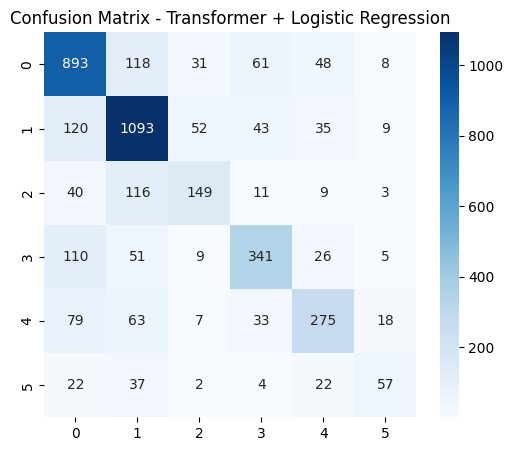

In [35]:
cr_logreg_transf = classification_report(y_test, y_pred_logreg, digits=3)
print("Classification Report - Transformer + Logistic Regression:\n", cr_logreg_transf)

cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6,5))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix - Transformer + Logistic Regression")
plt.show()

KNN su Transfrmeriu

In [36]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {'n_neighbors': np.arange(3, 15, 1), 'weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_emb, y_train)
best_params_knn = grid_knn.best_params_
best_knn = KNeighborsClassifier(n_neighbors=best_params_knn['n_neighbors'], weights=best_params_knn['weights'])
cv_scores_knn = cross_val_score(best_knn, X_emb, y, cv=10, scoring='accuracy', n_jobs=-1)
best_knn.fit(X_train_emb, y_train)
y_pred_knn = best_knn.predict(X_test_emb)

print("KNN Best Params:", best_params_knn)
print("KNN CV Mean:", cv_scores_knn.mean())

KNN Best Params: {'n_neighbors': np.int64(14), 'weights': 'distance'}
KNN CV Mean: 0.71255


Classification Report - Transformer + KNN:
               precision    recall  f1-score   support

           0      0.706     0.841     0.768      1159
           1      0.724     0.837     0.776      1352
           2      0.742     0.473     0.577       328
           3      0.808     0.629     0.707       542
           4      0.735     0.589     0.654       475
           5      0.756     0.236     0.360       144

    accuracy                          0.729      4000
   macro avg      0.745     0.601     0.640      4000
weighted avg      0.734     0.729     0.719      4000



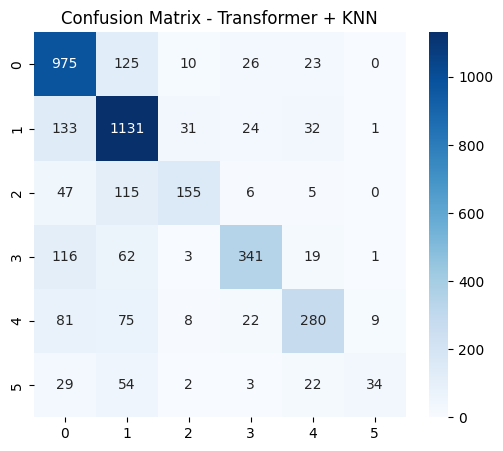

In [37]:
cr_knn_transf = classification_report(y_test, y_pred_knn, digits=3)
print("Classification Report - Transformer + KNN:\n", cr_knn_transf)

cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6,5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix - Transformer + KNN")
plt.show()  

SVM su transformeriu

In [38]:
from sklearn.svm import LinearSVC

param_grid_svc = {'C':[0.01,0.1,1,10,100]}
grid_svc = GridSearchCV(LinearSVC(random_state=42), param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train_emb, y_train)
best_params_svc = grid_svc.best_params_
best_svc = LinearSVC(C=best_params_svc['C'], random_state=42)
cv_scores_svc = cross_val_score(best_svc, X_emb, y, cv=10, scoring='accuracy', n_jobs=-1)
best_svc.fit(X_train_emb, y_train)
y_pred_svc = best_svc.predict(X_test_emb)

print("SVM Best Params:", best_params_svc)
print("SVM CV Mean:", cv_scores_svc.mean())

SVM Best Params: {'C': 10}
SVM CV Mean: 0.69195


Classification Report - Transformer + SVM:
               precision    recall  f1-score   support

           0      0.698     0.787     0.740      1159
           1      0.733     0.825     0.777      1352
           2      0.633     0.384     0.478       328
           3      0.684     0.603     0.641       542
           4      0.682     0.583     0.629       475
           5      0.602     0.368     0.457       144

    accuracy                          0.703      4000
   macro avg      0.672     0.592     0.620      4000
weighted avg      0.697     0.703     0.694      4000



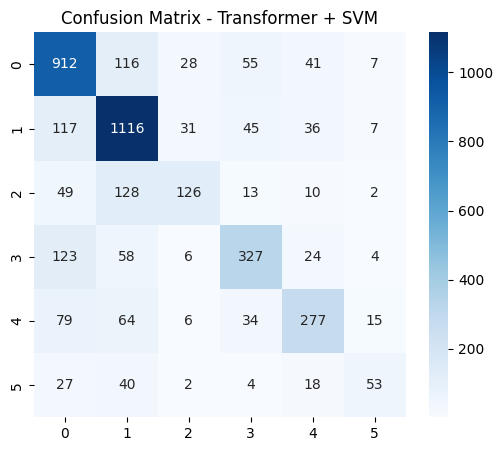

In [39]:
cr_transf_svc = classification_report(y_test, y_pred_svc, digits=3)
print("Classification Report - Transformer + SVM:\n", cr_transf_svc)

cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6,5))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix - Transformer + SVM")
plt.show()

CV (10) rezultatai

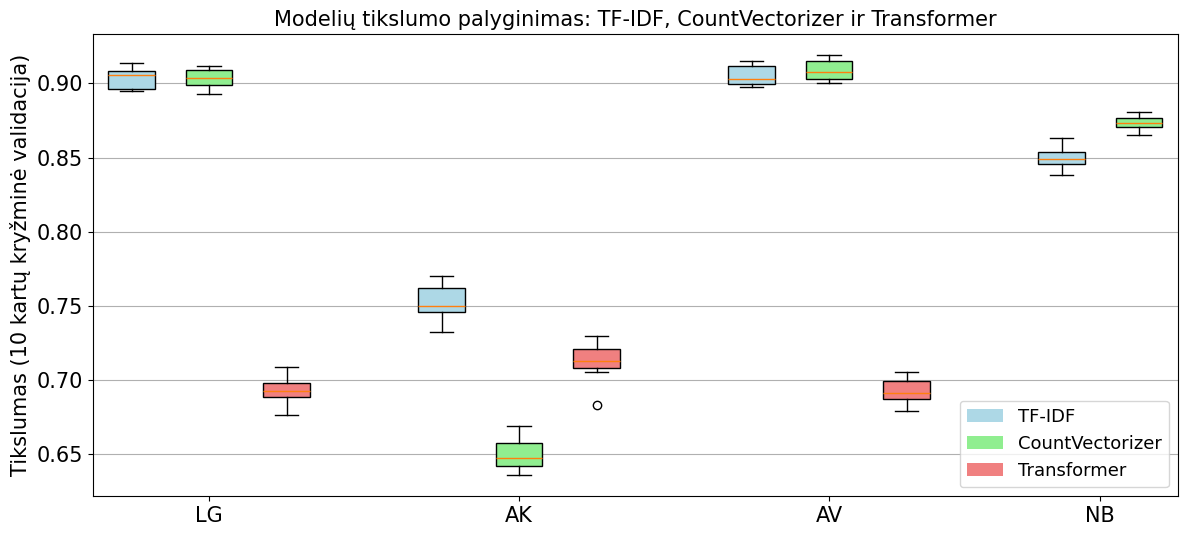

In [58]:
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams.update({
    'font.size': 16,          
    'axes.titlesize': 15,     
    'axes.labelsize': 15,     
    'xtick.labelsize': 15,    
    'ytick.labelsize': 15,    
    'legend.fontsize': 13,    
})

all_scores = [
    [cv_scores_tfidf_logreg, cv_scores_count_logreg, cv_scores_logreg],
    [cv_scores_tfidf_knn, cv_scores_count_knn, cv_scores_knn],
    [cv_scores_tfidf_svc, cv_scores_count_svc, cv_scores_svc],
    [cv_scores_tfidf_nb, cv_scores_count_nb]  
]

model_names = ["LG", "AK", "AV", "NB"]

positions = []
data = []
colors = []

for i, scores_list in enumerate(all_scores):
    if len(scores_list) == 3: 
        positions.append([i*4 + 1, i*4 + 2, i*4 + 3])
        data.extend(scores_list)
        colors.extend(['lightblue', 'lightgreen', 'lightcoral'])
    else:  # NB with only 2 methods
        positions.append([i*4 + 1, i*4 + 2])
        data.extend(scores_list)
        colors.extend(['lightblue', 'lightgreen'])

pos = [p for pair in positions for p in pair]

fig, ax = plt.subplots(figsize=(14,6))

bplots = ax.boxplot(data, positions=pos, widths=0.6, patch_artist=True)

for patch, color in zip(bplots['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks([np.mean(p) for p in positions])
ax.set_xticklabels(model_names)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='lightblue', label='TF-IDF'),
                   Patch(facecolor='lightgreen', label='CountVectorizer'),
                   Patch(facecolor='lightcoral', label='Transformer')]
ax.legend(handles=legend_elements, loc='lower right')

ax.set_ylabel("Tikslumas (10 kartų kryžminė validacija)")
ax.set_title("Modelių tikslumo palyginimas: TF-IDF, CountVectorizer ir Transformer")
ax.grid(True, axis='y')
plt.show()


## BERT ##

Device set to use cpu
C:\Users\ignas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Classification Report - BERT Transformer:
               precision    recall  f1-score   support

           0      0.997     0.981     0.989      1159
           1      0.980     0.988     0.984      1352
           2      0.969     0.942     0.955       328
           3      0.987     0.963     0.975       542
           4      0.925     0.983     0.953       475
           5      0.931     0.931     0.931       144

    accuracy                          0.976      4000
   macro avg      0.965     0.965     0.964      4000
weighted avg      0.977     0.976     0.976      4000



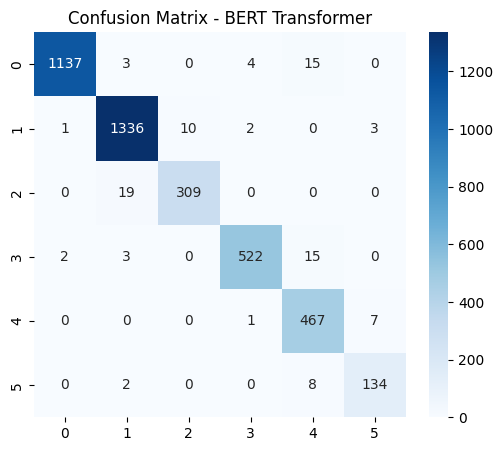

In [41]:
from transformers import pipeline

classifier = pipeline("text-classification",
                      model="bhadresh-savani/bert-base-uncased-emotion",
                      return_all_scores=False)

X = df_full['text']
y = df_full['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_pred_bert = [classifier(text)[0]['label'] for text in X_test]
label_mapping = {
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5
}

y_pred_bert_mapped = [label_mapping[label] for label in y_pred_bert]
cr_bert = classification_report(y_test, y_pred_bert_mapped, digits=3)
print("Classification Report - BERT Transformer:\n", cr_bert)

cm_bert = confusion_matrix(y_test, y_pred_bert_mapped)
plt.figure(figsize=(6,5))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix - BERT Transformer")
plt.show()  

Model Performance Comparison on Test Set:
                            Model Accuracy Precision Recall F1-Score
     TF-IDF + Logistic Regression    0.907     0.882  0.855    0.867
   CountVec + Logistic Regression    0.911     0.885  0.860    0.872
Transformer + Logistic Regression    0.702     0.661  0.606    0.628
                     TF-IDF + KNN    0.766     0.814  0.656    0.701
                   CountVec + KNN    0.642     0.626  0.556    0.579
                Transformer + KNN    0.729     0.745  0.601    0.640
                     TF-IDF + SVM    0.912     0.888  0.869    0.878
                   CountVec + SVM    0.915     0.891  0.870    0.880
                Transformer + SVM    0.703     0.672  0.592    0.620
             TF-IDF + Naive Bayes    0.855     0.866  0.737    0.782
           CountVec + Naive Bayes    0.878     0.841  0.824    0.832
                 BERT Transformer    0.976     0.965  0.965    0.964


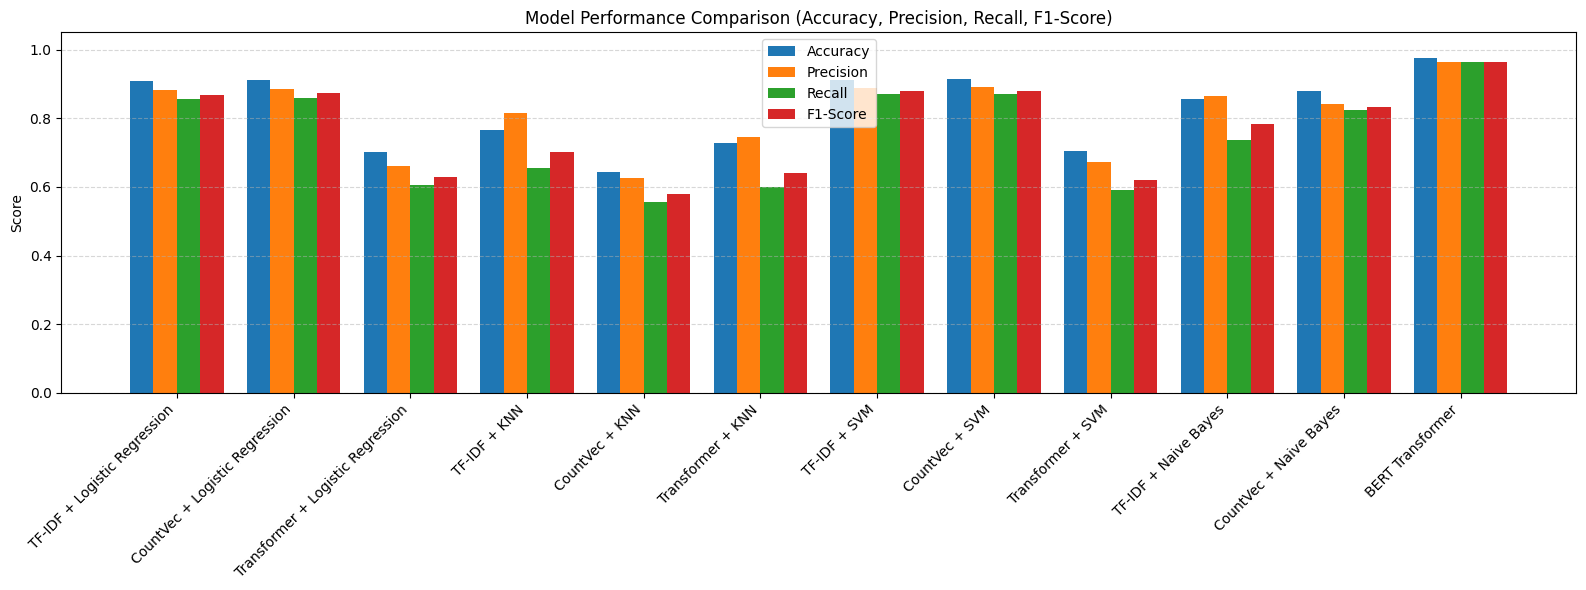

In [42]:
models = {
    "TF-IDF + Logistic Regression": cr_logreg_tfidf,
    "CountVec + Logistic Regression": cr_count_logreg,
    "Transformer + Logistic Regression": cr_logreg_transf,
    "TF-IDF + KNN": cr_knn_tfidf,    
    "CountVec + KNN": cr_count_knn,
    "Transformer + KNN": cr_knn_transf,
    "TF-IDF + SVM": cr_svc_tfidf,
    "CountVec + SVM": cr_count_svc,
    "Transformer + SVM": cr_transf_svc,
    "TF-IDF + Naive Bayes": cr_nb_tfidf,
    "CountVec + Naive Bayes": cr_count_nb,
    "BERT Transformer": cr_bert
}

import pandas as pd
import re

results = []

for model, cr_text in models.items():
    # Extract macro avg metrics
    macro_match = re.search(r'macro avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', cr_text)
    if macro_match:
        precision = float(macro_match.group(1))
        recall = float(macro_match.group(2))
        f1_score = float(macro_match.group(3))
    else:
        precision = recall = f1_score = None

    # Extract accuracy
    acc_match = re.search(r'accuracy\s+([\d.]+)', cr_text)
    accuracy = float(acc_match.group(1)) if acc_match else None

    results.append({
        'Model': model,
        'Accuracy': f"{accuracy:.3f}" if accuracy is not None else None,
        'Precision': f"{precision:.3f}" if precision is not None else None,
        'Recall': f"{recall:.3f}" if recall is not None else None,
        'F1-Score': f"{f1_score:.3f}" if f1_score is not None else None
    })

results_df = pd.DataFrame(results)
print("Model Performance Comparison on Test Set:")
print(results_df.to_string(index=False))

results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']] = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].astype(float)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results_df['Model']))  # positions for models
width = 0.2  # bar width

plt.figure(figsize=(16, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i*width - width*1.5, 
            results_df[metric], 
            width, 
            label=metric)

plt.xticks(x, results_df['Model'], rotation=45, ha="right")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Performance Comparison (Accuracy, Precision, Recall, F1-Score)")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
import pandas as pd
import re
import numpy as np

# Collect all unique labels from all reports
all_labels = set()
for cr_text in models.values():
    label_matches = re.findall(r'^\s*(\d+)\s+', cr_text, re.MULTILINE)
    all_labels.update(label_matches)
all_labels = sorted(list(all_labels), key=int)

# Build table
table_data = []

for model_name, cr_text in models.items():
    row = {'Model': model_name}
    for label in all_labels:
        # Regex to find F1-score for the class
        match = re.search(rf'^\s*{label}\s+[\d.]+\s+[\d.]+\s+([\d.]+)', cr_text, re.MULTILINE)
        f1 = float(match.group(1)) if match else np.nan
        row[label] = f"{f1:.3f}" if f1 is not np.nan else None
    table_data.append(row)

f1_table = pd.DataFrame(table_data)
print("F1-Scores per Class for Each Model:")
print(f1_table.to_string(index=False), '\n')

print("Worst Performing Classes per Model (Lowest F1-Scores):", 
      f1_table.set_index('Model').astype(float).idxmin(axis=1).to_dict())

print("Best Performing Classes per Model (Highest F1-Scores):", 
      f1_table.set_index('Model').astype(float).idxmax(axis=1).to_dict())

F1-Scores per Class for Each Model:
                            Model     0     1     2     3     4     5
     TF-IDF + Logistic Regression 0.942 0.928 0.805 0.900 0.877 0.753
   CountVec + Logistic Regression 0.946 0.934 0.828 0.896 0.878 0.750
Transformer + Logistic Regression 0.737 0.772 0.516 0.659 0.618 0.467
                     TF-IDF + KNN 0.807 0.796 0.571 0.753 0.733 0.545
                   CountVec + KNN 0.684 0.712 0.492 0.546 0.571 0.469
                Transformer + KNN 0.768 0.776 0.577 0.707 0.654 0.360
                     TF-IDF + SVM 0.946 0.931 0.825 0.907 0.878 0.780
                   CountVec + SVM 0.947 0.937 0.835 0.906 0.884 0.770
                Transformer + SVM 0.740 0.777 0.478 0.641 0.629 0.457
             TF-IDF + Naive Bayes 0.895 0.885 0.690 0.856 0.814 0.550
           CountVec + Naive Bayes 0.918 0.906 0.777 0.869 0.837 0.683
                 BERT Transformer 0.989 0.984 0.955 0.975 0.953 0.931 

Worst Performing Classes per Model (Lowest F1-Scores

In [44]:
# Pavyzdžiai, kur BERT suklydo
bert_errors = pd.DataFrame({
    "text": X_test,
    "true": y_test.map({v: k for k, v in label_mapping.items()}),
    "pred": [k for k in y_pred_bert]
})

sample_errors = bert_errors[bert_errors['true'] != bert_errors['pred']].sample(20, random_state=42)
print("Klaidingai klasifikuoti pavyzdžiai (BERT):\n")
for _, row in sample_errors.iterrows():
    print(f"Text: {row['text']}\nTrue: {row['true']} | Predicted: {row['pred']}\n")


Klaidingai klasifikuoti pavyzdžiai (BERT):

Text: i feel blessed to be able to see that we didn t do anything
True: joy | Predicted: love

Text: im already feeling less agitated
True: anger | Predicted: fear

Text: i hate this feeling of helpless
True: sadness | Predicted: fear

Text: i cant help but feel so helpless
True: sadness | Predicted: fear

Text: i feel so strange with english right now
True: fear | Predicted: surprise

Text: i want as much of you as you are willing to give me and i plan on making you feel very generous
True: joy | Predicted: love

Text: i cant escape the tears of sadness and just true grief i feel at the loss of my sweet friend and sister
True: love | Predicted: joy

Text: i am feeling overwhelmed by trying to do it all that i think on the women before me
True: surprise | Predicted: fear

Text: i am energetically pursuing my goals or i feel agitated and unable to sit still
True: anger | Predicted: fear

Text: i bet taylor swift basks in the knowledge that the